In [1]:
import gymnasium as gym
from bettermdptools.envs.cartpole_wrapper import CartpoleWrapper
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.algorithms.planner import Planner
from bettermdptools.algorithms.rl import RL
import numpy as np
import matplotlib.pyplot as plt
from bettermdptools.utils.plots import Plots
from bettermdptools.utils.decorators import add_to
import seaborn as sns

/opt/anaconda3/envs/ml-hw4/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Q-learning

In [3]:
base_env = gym.make('CartPole-v1', render_mode=None)
cartpole = CartpoleWrapper(base_env)

Q, V, Q_pi, Q_track, pi_track, rewards = RL(cartpole).q_learning()

test_scores = TestEnv.test_env(env=cartpole, n_iters=100, render=False, pi=Q_pi, user_input=False)
print(np.mean(test_scores))

 33%|███▎      | 3337/10000 [00:25<01:25, 78.18it/s] /opt/anaconda3/envs/ml-hw4/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:177: UserWarning: Episode was truncated.  TD target value may be incorrect.
  warnings.warn(


288.52


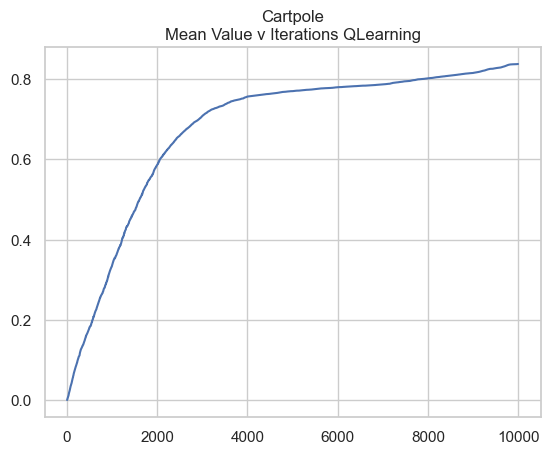

In [4]:
V_track = np.max(Q_track, axis=2)

max_value_per_iter = np.trim_zeros(np.mean(V_track, axis=1), 'b')
Plots.v_iters_plot(max_value_per_iter, "Cartpole\nMean Value v Iterations QLearning")

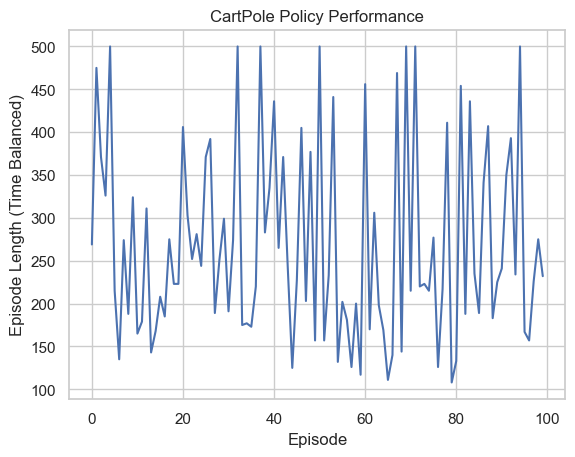

Average episode length: 268.12


In [10]:
def evaluate_policy_tabular(env, policy, n_episodes=100):
    lengths = []

    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_steps = 0

        while not done:
            state = int(obs)
            action = policy.get(state, env.action_space.sample())
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_steps += 1

        lengths.append(total_steps)

    return lengths

episode_lengths = evaluate_policy_tabular(cartpole, Q_pi, n_episodes=100)

plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length (Time Balanced)")
plt.title("CartPole Policy Performance")
plt.grid(True)
plt.show()

print(f"Average episode length: {np.mean(episode_lengths):.2f}")

# Sarsa

In [11]:
base_env = gym.make('CartPole-v1', render_mode=None)
cartpole = CartpoleWrapper(base_env)

Q_s, V_s, Q_pi_s, Q_track_s, pi_track_s, rewards_s = RL(cartpole).sarsa()

test_scores = TestEnv.test_env(env=cartpole, n_iters=100, render=False, pi=Q_pi_s, user_input=False)
print(np.mean(test_scores))


 30%|██▉       | 2971/10000 [00:22<01:46, 66.24it/s] /opt/anaconda3/envs/ml-hw4/lib/python3.11/site-packages/bettermdptools/algorithms/rl.py:285: UserWarning: Episode was truncated.  TD target value may be incorrect.
  warnings.warn(


186.11


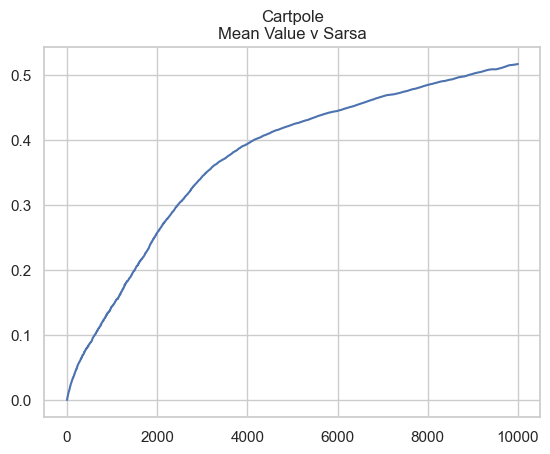

In [12]:
V_track_s = np.max(Q_track_s, axis=2)
max_value_per_iter = np.trim_zeros(np.mean(V_track_s, axis=1), 'b')
Plots.v_iters_plot(max_value_per_iter, "Cartpole\nMean Value v Sarsa")

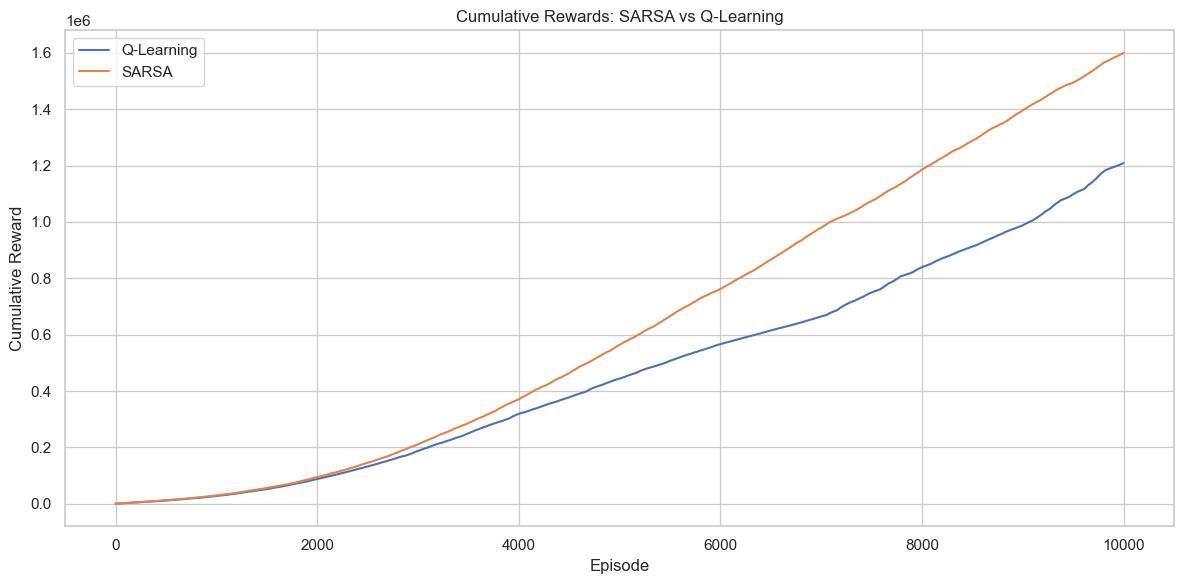

In [13]:
q_cumulative = np.cumsum(rewards)
sarsa_cumulative = np.cumsum(rewards_s)

plt.figure(figsize=(12, 6))
plt.plot(q_cumulative, label="Q-Learning")
plt.plot(sarsa_cumulative, label="SARSA")

plt.title("Cumulative Rewards: SARSA vs Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

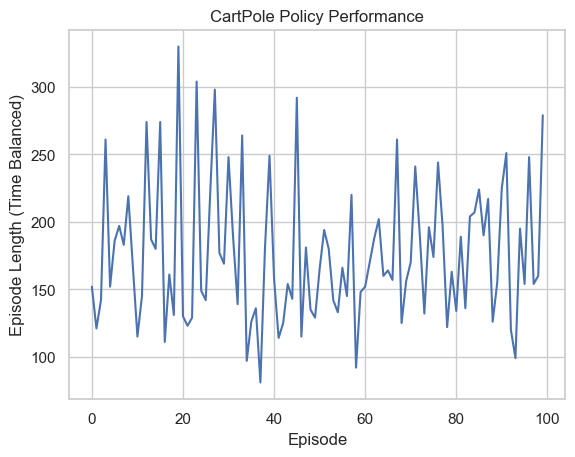

Average episode length: 176.03


In [16]:
def evaluate_policy_tabular(env, policy, n_episodes=100):
    lengths = []

    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_steps = 0

        while not done:
            state = int(obs)
            action = policy.get(state, env.action_space.sample())
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_steps += 1

        lengths.append(total_steps)

    return lengths

episode_lengths = evaluate_policy_tabular(cartpole, Q_pi_s, n_episodes=100)

plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length (Time Balanced)")
plt.title("CartPole Policy Performance")
plt.grid(True)
plt.show()

print(f"Average episode length: {np.mean(episode_lengths):.2f}")

In [17]:
def compare_policies(pi_value, pi_policy):
    all_states = set(pi_value.keys()).union(set(pi_policy.keys()))
    mismatches = []

    for s in all_states:
        a_value = pi_value.get(s)
        a_policy = pi_policy.get(s)
        if a_value != a_policy:
            mismatches.append((s, a_value, a_policy))

    if not mismatches:
        print("✅ Value Iteration and Policy Iteration produce the SAME policy.")
    else:
        print(f"❌ Policies differ at {len(mismatches)} states.")
        print("Examples (state, value_iter_action, policy_iter_action):")
        for m in mismatches[:10]:
            print(m)

compare_policies(Q_pi, Q_pi_s)

❌ Policies differ at 1926 states.
Examples (state, value_iter_action, policy_iter_action):
(5, 1, 0)
(7, 0, 1)
(14, 1, 0)
(15, 1, 0)
(17, 0, 1)
(26, 1, 0)
(35, 1, 0)
(55, 0, 1)
(65, 1, 0)
(66, 1, 0)


# Episode Over Time

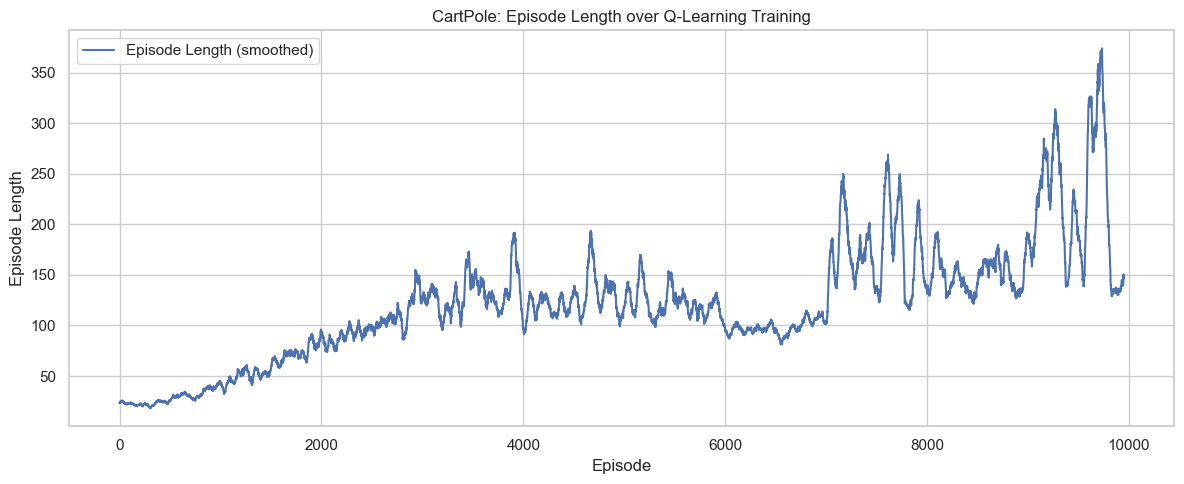

In [20]:
def moving_average(x, window=50):
    return np.convolve(x, np.ones(window)/window, mode='valid')

episode_lengths = rewards

plt.figure(figsize=(12, 5))
plt.plot(moving_average(episode_lengths), label="Episode Length (smoothed)")
plt.title("CartPole: Episode Length over Q-Learning Training")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

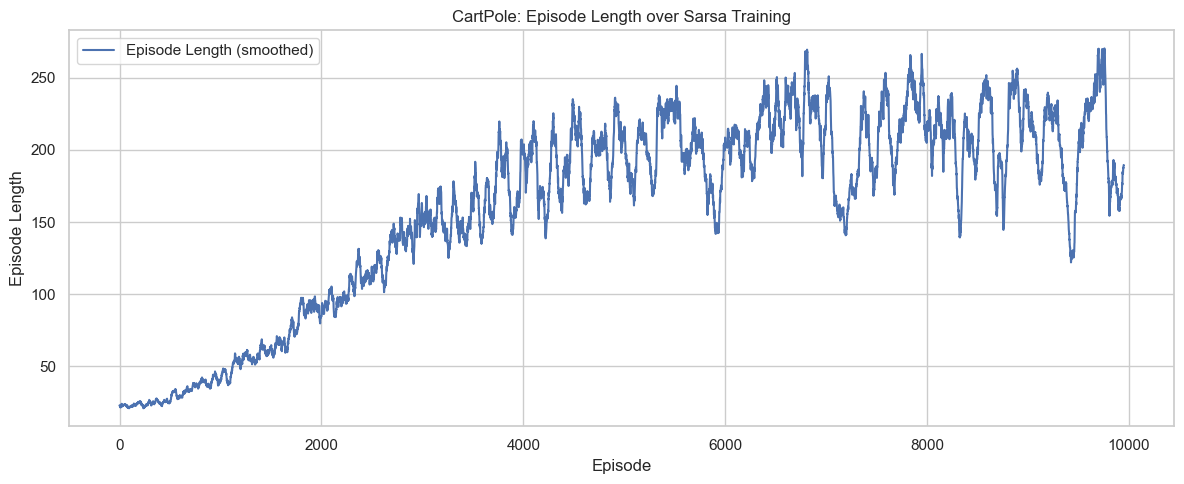

In [21]:
def moving_average(x, window=50):
    return np.convolve(x, np.ones(window)/window, mode='valid')

episode_lengths = rewards_s

plt.figure(figsize=(12, 5))
plt.plot(moving_average(episode_lengths), label="Episode Length (smoothed)")
plt.title("CartPole: Episode Length over Sarsa Training")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()